In [256]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

def c_generate(x_range):
    bin=len(x_range)
    C=np.random.random((bin,bin))
    for i in range(bin):
        for j in range(bin):
            C[i,j]=abs(x_range[i]-x_range[j])
    return C

def normialise(tem_dist):
    return [tem_dist[i]/sum(tem_dist) for i in range(len(tem_dist))]

def tmp_generator(gamma_dict,num,q_dict,q_num,L):
    bin=gamma_dict[0].shape[0]
    if q_num<=0:
        q=np.matrix(np.ones((bin,bin)))
    else:
        q=q_dict[q_num]
    tmp_gamma=np.zeros((bin,bin))
    tmp_q=np.zeros((bin,bin))
    for i in range(bin):
        for j in range(bin):
            tmp_gamma[i,j]=q.item(i,j)*gamma_dict[num-1].item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
            tmp_q[i,j]=q.item(i,j)*gamma_dict[num-L-1].item(i,j)/gamma_dict[num-L].item(i,j)
    return np.matrix(tmp_gamma),np.matrix(tmp_q)     

def samples_groupby(data):
    # for better complexity
    df=data.groupby(by=['X','S','Y'],as_index=False).sum()
    return df[df['W']!=0]

def assess(bin,f,g,C,V,output):
    output=output.A1.reshape((bin,bin))
    print('sum of violation of f:',sum(abs(np.sum(output,1)-f)))
    print('sum of violation of g:',sum(abs(np.sum(output,0)-g)))
    print('total cost:',sum(sum(output*C)))
    print('entropy:',sum(sum(-output*np.log(output+0.1**3))))
    print('tr violation:',sum(abs(output.T@V)))
    print('============================================')

def plots(x_range,g,f,output):
    fig = plt.figure(figsize=(3,3))
    gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4),left=0.1,right=0.9,bottom=0.1, top=0.9,wspace=0,hspace=0)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax.pcolormesh(x_range, x_range, output, cmap='Blues')
    ax.set_xlabel(r'supp($X$)',fontsize=10)
    ax.set_ylabel(r'supp($\tilde{X}$)',fontsize=10)#
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax) 
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    #ax_histx.set_title(r'$Pr[x]$',rotation='horizontal')
    #ax_histy.set_title(r'$Pr[\tilde{x}]$')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histx.plot(x_range,g,color='tab:blue')
    ax_histy.plot(f,x_range,color='tab:green') 
    return fig

def v_value(x0,x1,x):
    if x != 0:
        return (x0-x1)/x
    else:
        return 0
    
def newton(fun,dfun,a, stepmax, tol):
    if abs(fun(a))<=tol: return a
    for step in range(1, stepmax+1):
        b=a-fun(a)/dfun(a)
        if abs(fun(b))<=tol:
            return b
        else:
            a = b
    return b 

# simplist
def baseline(C,e,px,ptx,V,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    #I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    gamma_classic=dict()
    gamma_classic[0]=np.matrix(xi+1.0e-9)
    for repeat in range(K):
        gamma_classic[1+2*repeat]=np.matrix(np.diag((px/(gamma_classic[2*repeat] @ bbm1)).A1))@gamma_classic[2*repeat] #np.diag(dist['x']/sum(gamma_classic.T))@gamma_classic
        gamma_classic[2+2*repeat]=gamma_classic[1+2*repeat]@np.matrix(np.diag((ptx/(gamma_classic[1+2*repeat].T @ bbm1)).A1))

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_classic[2*K])
    return gamma_classic

# our method | total repair
def total_repair(C,e,px,ptx,V,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    gamma_dict=dict()
    gamma_dict[0]=np.matrix(xi+1.0e-9)
    gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
    gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
    # step 3
    J=np.where(~((gamma_dict[2].T @ V).A1 ==0))[0].tolist()
    nu=np.zeros(bin)
    gamma_dict[3]=np.copy(gamma_dict[2])
    for j in J:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
        dfun = lambda z: sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(nu*V.item(i))*gamma_dict[2].item(i,j)
    gamma_dict[3]=np.matrix(gamma_dict[3])

    #=========================
    L=3
    q_dict=dict()
    for loop in range(1,K):
        tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
        gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

        tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
        gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

        # step 3
        tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
        J=np.where(~((abs(np.matrix(tmp).T @ V).A1)<=1.0e-5))[0].tolist()
        gamma_dict[loop*L+3]=np.copy(tmp)
        for j in J:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(z*V.item(i)) for i in I)
            dfun = lambda z: sum(tmp.item(i,j)*(V.item(i))**2*np.exp(z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(nu*V.item(i))*tmp.item(i,j)
        gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[K*L])
    return gamma_dict

# our method | partial repair
def partial_repair(C,e,px,ptx,V,theta_scale,K):
    bin=len(px)
    bbm1=np.matrix(np.ones(bin)).T
    I=np.where(~(V==0))[0].tolist()
    xi=np.exp(-C/e)
    theta=bbm1*theta_scale
    gamma_dict=dict()
    gamma_dict[0]=np.matrix(xi+1.0e-9)
    gamma_dict[1]=np.matrix(np.diag((px/(gamma_dict[0] @ bbm1)).A1))@gamma_dict[0]
    gamma_dict[2]=gamma_dict[1]@np.matrix(np.diag((ptx/(gamma_dict[1].T @ bbm1)).A1))
    # step 3
    Jplus=np.where(~((gamma_dict[2].T @ V).A1 <=theta.A1))[0].tolist()
    Jminus=np.where(~((gamma_dict[2].T @ V).A1>=-theta.A1))[0].tolist()
    gamma_dict[3]=np.copy(gamma_dict[2])
    for j in Jplus:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)-theta.item(j)
        dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(-nu*V.item(i))*gamma_dict[2].item(i,j)
    for j in Jminus:
        fun = lambda z: sum(gamma_dict[2].item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)+theta.item(j)
        dfun = lambda z: -sum(gamma_dict[2].item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
        nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-3) #bisection(fun, -50,50, stepmax = 25, tol = 1.0e-3)
        for i in I:
            gamma_dict[3][i,j]=np.exp(-nu*V.item(i))*gamma_dict[2].item(i,j)
    gamma_dict[3]=np.matrix(gamma_dict[3])

    #=========================
    L=3
    q_dict=dict()
    for loop in range(1,K):
        tmp,q_dict[(loop-1)*L+1]=tmp_generator(gamma_dict,loop*L+1,q_dict,(loop-2)*L+1,L) #np.matrix(gamma_dict[3].A1*gamma_dict[0].A1/gamma_dict[1].A1)
        gamma_dict[loop*L+1]=np.matrix(np.diag((px/(tmp @ bbm1)).A1))@tmp

        tmp,q_dict[(loop-1)*L+2]=tmp_generator(gamma_dict,loop*L+2,q_dict,(loop-2)*L+2,L)  #np.matrix(gamma_dict[4].A1*gamma_dict[1].A1/gamma_dict[2].A1)
        gamma_dict[loop*L+2]=tmp@np.matrix(np.diag((ptx/(tmp.T @ bbm1)).A1))

        # step 3
        tmp,q_dict[(loop-1)*L+3]=tmp_generator(gamma_dict,loop*L+3,q_dict,(loop-2)*L+3,L)  #np.matrix(gamma_dict[5].A1*gamma_dict[2].A1/gamma_dict[3].A1)
        Jplus=np.where(~((np.matrix(tmp).T @ V).A1 <=theta.A1))[0].tolist()
        Jminus=np.where(~((np.matrix(tmp).T @ V).A1>=-theta.A1))[0].tolist()
        gamma_dict[loop*L+3]=np.copy(tmp)
        for j in Jplus:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)-theta.item(j)
            dfun = lambda z: -sum(tmp.item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(-nu*V.item(i))*tmp.item(i,j)
        for j in Jminus:
            fun = lambda z: sum(tmp.item(i,j)*V.item(i)*np.exp(-z*V.item(i)) for i in I)+theta.item(j)
            dfun = lambda z: -sum(tmp.item(i,j)*(V.item(i))**2*np.exp(-z*V.item(i)) for i in I)
            nu = newton(fun,dfun,0.5,stepmax = 25,tol = 1.0e-5) 
            for i in I:
                gamma_dict[loop*L+3][i,j]=np.exp(-nu*V.item(i))*tmp.item(i,j)
        gamma_dict[loop*L+3]=np.matrix(gamma_dict[loop*L+3])

    assess(bin,dist['x'],dist['t_x'],C,V,gamma_dict[L*K])
    return gamma_dict

def empirical_distribution(sub,x_range):
    bin=len(x_range)
    distrition=np.zeros(bin)
    for i in range(bin):
        subset=sub[sub['X']==x_range[i]] #bin_value=x_range[i] #sub[(sub['X']>=bin_value)&(sub['X']<bin_value+width)]
        if subset.shape[0]>0:
            distrition[i]=sum(subset['W'])
    if sum(distrition)>0:
        return distrition/sum(distrition)
    else:
        return distrition

def rdata_analysis(rdata,x_range):
    rdist=dict()
    rdist['x']=empirical_distribution(rdata,x_range)
    rdist['x_0']=empirical_distribution(rdata[rdata['S']==0],x_range)
    rdist['x_1']=empirical_distribution(rdata[rdata['S']==1],x_range)
    return rdist

def projection(df,coupling_matrix,x_range):
    bin=len(x_range)
    coupling=coupling_matrix.A1.reshape((bin,bin))
    df_t=pd.DataFrame(columns=['X','S','W','Y'])
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        loc=np.where(x_range==orig[0])[0][0]
        rows=np.nonzero(coupling[loc,:])[0]
        sub=pd.DataFrame(columns=['X','W'],index=rows)
        sub['X']=x_range[rows]
        sub['W']=coupling[loc,rows]/(sum(coupling[loc,rows]))*orig[2]
        sub['S']=orig[1]
        sub['Y']=orig[3]
        df_t=pd.concat([df_t, samples_groupby(sub)], ignore_index=True)
    return df_t

def plot_rdist(rdist,x_range):
    plt.plot(x_range,rdist['x'],label=r'$Pr[x]$',color='tab:blue')
    plt.plot(x_range,rdist['x_0'],label=r'$Pr[x|s_0]$',alpha=0.3,color='tab:orange')
    plt.plot(x_range,rdist['x_1'],label=r'$Pr[x|s_1]$',alpha=0.3,color='#9f86c0')
    plt.ylabel('PMF',fontsize=14)
    plt.xlabel(r'$supp(X)=supp(\tilde{X})$',fontsize=20)
    plt.legend()
    return plt

# def DisparateImpact(X_test,y_test,y_pred):
#     df_test=pd.DataFrame(np.concatenate((X_test,y_test.reshape(-1,1),y_pred.reshape(-1,1)), axis=1),columns=['X','S','W','Y','f'])
#     numerator=sum(df_test[(df_test['S']==0)&(df_test['f']==1)&(df_test['Y']==1)]['W'])/sum(df_test[(df_test['S']==0)&(df_test['Y']==1)]['W'])
#     denominator=sum(df_test[(df_test['S']==1)&(df_test['f']==1)&(df_test['Y']==1)]['W'])/sum(df_test[(df_test['S']==1)&(df_test['Y']==1)]['W'])
#     return numerator/denominator

def DisparateImpact(X_test,y_pred):
    df_test=pd.DataFrame(np.concatenate((X_test,y_pred.reshape(-1,1)), axis=1),columns=['X','S','W','f'])
    numerator=sum(df_test[(df_test['S']==0)&(df_test['f']==1)]['W'])/sum(df_test[df_test['S']==0]['W'])
    denominator=sum(df_test[(df_test['S']==1)&(df_test['f']==1)]['W'])/sum(df_test[df_test['S']==1]['W'])
    if numerator==denominator:
        return 1
    return numerator/denominator

In [2]:
pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/adult_csv.csv').head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


In [4]:
messydata=pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/adult_csv.csv',usecols=['race','education-num','class'])
messydata=messydata[(messydata['race']=='White')|(messydata['race']=='Black')]
messydata['race']=messydata['race'].replace('White',1)
messydata['race']=messydata['race'].replace('Black',0)
messydata['class']=messydata['class'].replace('>50K',1)
messydata['class']=messydata['class'].replace('<=50K',0)
for col in ['race','education-num','class']:
    messydata[col]=messydata[col].astype('category')
messydata=messydata.rename(columns={'education-num':'X','race':'S','class':'Y'})
messydata['W']=1

X=messydata[['X','S','W']].to_numpy()
y=messydata['Y'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=222)

In [9]:
df=pd.DataFrame(np.concatenate((X_train,y_train.reshape(-1,1)), axis=1),columns=['X','S','W','Y'])
#x_range=np.arange(min(df['X']),max(df['X'])+1,1)

In [10]:
K=200
df=pd.DataFrame(np.concatenate((X_train,y_train.reshape(-1,1)), axis=1),columns=['X','S','W','Y'])
x_range=np.arange(min(df['X']),max(df['X'])+1,1)
bin=len(x_range)
dist=rdata_analysis(df,x_range)
dist['t_x']=dist['x_0']
dist['v']=[v_value(dist['x_0'][i],dist['x_1'][i],dist['x'][i]) for i in range(bin)]

e=0.01
C=c_generate(x_range)
px=np.matrix(dist['x']).T
ptx=np.matrix(dist['t_x']).T
V=np.matrix(dist['v']).T
rdata_part2=projection(df,partial_repair(C,e,px,ptx,V,1.0e-2,K)[K*3],x_range)
#rdata_part2.to_csv('C:/Users/zhouq/Documents/optimal_transport/rdata_part2.csv',index=None)
rdata_base=projection(df,baseline(C,e,px,ptx,V,K)[K*2],x_range)
#rdata_base.to_csv('C:/Users/zhouq/Documents/optimal_transport/rdata_base.csv',index=None)
#rdata_total=projection(df,total_repair(C,e,px,ptx,V,200)[600],x_range)
#rdata_total.to_csv('C:/Users/zhouq/Documents/optimal_transport/rdata_total.csv',index=None)
#rdist_total=rdata_analysis(rdata_total,x_range)
#plot_rdist(rdist_total,x_range)

sum of violation of f: 0.00569552393643857
sum of violation of g: 8.8158529328735e-05
total cost: 0.965205744572327
entropy: 2.48171171588779
tr violation: [[0.08289944]]


KeyboardInterrupt: 

In [279]:
x_name='education-num'
messydata=pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/adult_csv.csv',usecols=['race',x_name,'class'])
messydata=messydata[(messydata['race']=='White')|(messydata['race']=='Black')]
messydata['race']=messydata['race'].replace('White',1)
messydata['race']=messydata['race'].replace('Black',0)
messydata['class']=messydata['class'].replace('>50K',1)
messydata['class']=messydata['class'].replace('<=50K',0)
for col in ['race',x_name,'class']:
    messydata[col]=messydata[col].astype('category')
messydata=messydata.rename(columns={x_name:'X','race':'S','class':'Y'})
messydata['W']=1

X=messydata[['X','S','W']].to_numpy()
y=messydata['Y'].to_numpy()

e=0.01
K=150

report=pd.DataFrame(columns=['DI','f1 macro','f1 micro','f1 weighted','method','test set'])
for ignore in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    ind0=np.random.choice(np.where(X_test[:,1]==0)[0],sum(X_test[:,1]==1),replace=True)
    ind1=np.where(X_test[:,1]==1)[0]
    ind=np.concatenate((ind0,ind1))
    X_test_rw=X_test[ind,:]
    y_test_rw=y_test[ind]

    df=pd.DataFrame(np.concatenate((X_train,y_train.reshape(-1,1)), axis=1),columns=['X','S','W','Y'])
    df=df.groupby(by=['X','S','Y'],as_index=False).sum()
    df=df[['X','S','W','Y']]

    x_range=np.arange(min(df['X']),max(df['X'])+1,1)
    bin=len(x_range)
    C=c_generate(x_range)
    dist=rdata_analysis(df,x_range)
    dist['t_x']=dist['x_0'] #dist['x'] #dist['x'] #dist['x_0']*0.9+dist['x_1']*0.1 
    dist['v']=[v_value(dist['x_0'][i],dist['x_1'][i],dist['x'][i]) for i in range(bin)]
    px=np.matrix(dist['x']).T
    ptx=np.matrix(dist['t_x']).T
    V=np.matrix(dist['v']).T
    rdata_base=projection(df,baseline(C,e,px,ptx,V,K)[K*2],x_range)
    rdata_part2=projection(df,partial_repair(C,e,px,ptx,V,1.0e-2,K)[K*3],x_range)

    # assess===============
    X_train_orig=df[['X','S','W']].to_numpy()
    y_train_orig=df['Y'].to_numpy().astype('int8')
    clf=RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_orig[:,0:1],y_train_orig,sample_weight=X_train_orig[:,2])
    y_pred=clf.predict(X_test[:,0:1])
    new_row = pd.Series({'DI':DisparateImpact(X_test,y_pred),
                        'f1 macro':f1_score(y_test, y_pred, average='macro'),
                        'f1 micro':f1_score(y_test, y_pred, average='micro'),
                        'f1 weighted':f1_score(y_test, y_pred, average='weighted'),
                        'method':'origin','test set':'origin'})
    y_pred_orig_rw=clf.predict(X_test_rw[:,0:1])
    new_row_rw = pd.Series({'DI':DisparateImpact(X_test_rw,y_pred_orig_rw),
                        'f1 macro':f1_score(y_test_rw, y_pred_orig_rw, average='macro'),
                        'f1 micro':f1_score(y_test_rw, y_pred_orig_rw, average='micro'),
                        'f1 weighted':f1_score(y_test_rw, y_pred_orig_rw, average='weighted'),
                        'method':'origin','test set':'re-weighted'})
    X_train_base=rdata_base[['X','S','W']].to_numpy()
    y_train_base=rdata_base['Y'].to_numpy().astype('int8')
    clf_base=RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_base[:,0:1],y_train_base,sample_weight=X_train_base[:,2])
    y_pred_base=clf_base.predict(X_test[:,0:1])
    new_row_base = pd.Series({'DI':DisparateImpact(X_test,y_pred_base),
                    'f1 macro':f1_score(y_test, y_pred_base, average='macro'),
                    'f1 micro':f1_score(y_test, y_pred_base, average='micro'),
                    'f1 weighted':f1_score(y_test, y_pred_base, average='weighted'),
                    'method':'baseline','test set':'origin'})
    y_pred_base_rw=clf_base.predict(X_test_rw[:,0:1])
    new_row_base_rw = pd.Series({'DI':DisparateImpact(X_test_rw,y_pred_base_rw),
                        'f1 macro':f1_score(y_test_rw, y_pred_base_rw, average='macro'),
                        'f1 micro':f1_score(y_test_rw, y_pred_base_rw, average='micro'),
                        'f1 weighted':f1_score(y_test_rw, y_pred_base_rw, average='weighted'),
                        'method':'baseline','test set':'re-weighted'})
    X_train_part=rdata_part2[['X','S','W']].to_numpy()
    y_train_part=rdata_part2['Y'].to_numpy().astype('int8')
    clf_part2=RandomForestClassifier(max_depth=5, random_state=0).fit(X_train_part[:,0:1],y_train_part,sample_weight=X_train_part[:,2])
    y_pred_part=clf_part2.predict(X_test[:,0:1])
    new_row_part = pd.Series({'DI':DisparateImpact(X_test,y_pred_part),
                    'f1 macro':f1_score(y_test, y_pred_part, average='macro'),
                    'f1 micro':f1_score(y_test, y_pred_part, average='micro'),
                    'f1 weighted':f1_score(y_test, y_pred_part, average='weighted'),
                    'method':'partial repair','test set':'origin'})
    y_pred_part2_rw=clf_part2.predict(X_test_rw[:,0:1])
    new_row_part2_rw = pd.Series({'DI':DisparateImpact(X_test_rw,y_pred_part2_rw),
                        'f1 macro':f1_score(y_test_rw, y_pred_part2_rw, average='macro'),
                        'f1 micro':f1_score(y_test_rw, y_pred_part2_rw, average='micro'),
                        'f1 weighted':f1_score(y_test_rw, y_pred_part2_rw, average='weighted'),
                        'method':'partial repair','test set':'re-weighted'})
    report = pd.concat([report,new_row.to_frame().T,new_row_base.to_frame().T,new_row_part.to_frame().T], ignore_index=True)
    report = pd.concat([report,new_row_rw.to_frame().T,new_row_base_rw.to_frame().T,new_row_part2_rw.to_frame().T], ignore_index=True) #,new_row_part4_rw.to_frame().T

#report.to_csv('C:/Users/zhouq/Documents/optimal_transport/report.csv',index=None)

sum of violation of f: 0.004727172499758355
sum of violation of g: 7.39425881635114e-17
total cost: 0.5894480546547085
entropy: 2.312471812917611
tr violation: [[0.14564595]]
sum of violation of f: 0.006690166014104156
sum of violation of g: 0.00023995443889025065
total cost: 1.4961703765719157
entropy: 2.7107930185944986
tr violation: [[0.01420942]]
sum of violation of f: 0.004575228242339756
sum of violation of g: 1.691355389077387e-16
total cost: 0.5699271120607028
entropy: 2.300286069983208
tr violation: [[0.13571048]]
sum of violation of f: 0.007204025018103815
sum of violation of g: 7.33269957243995e-05
total cost: 1.4248116042604766
entropy: 2.6635665529449364
tr violation: [[0.01368931]]
sum of violation of f: 0.005928740151565801
sum of violation of g: 3.122502256758253e-17
total cost: 0.5339507753276747
entropy: 2.294360573054792
tr violation: [[0.12899042]]
sum of violation of f: 0.007114710244378854
sum of violation of g: 0.0001306682629327073
total cost: 1.4508141405033554

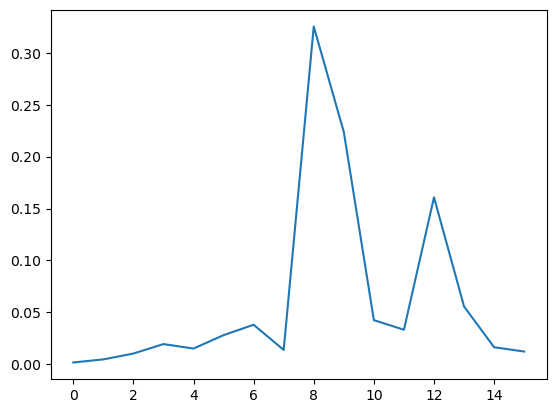

In [262]:
plt.plot(dist['x'])

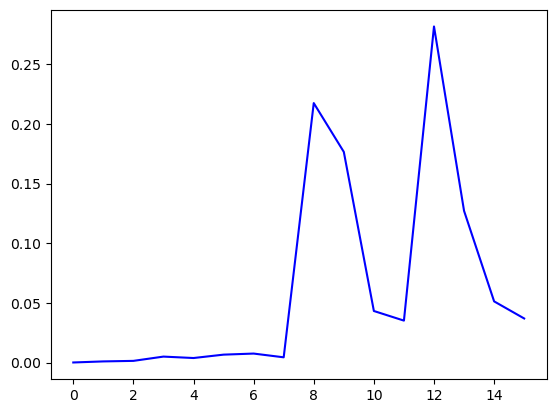

In [263]:
y=1
plt.plot([sum(df[(df['Y']==y)&(df['X']==i)]['W'])/sum([sum(df[(df['Y']==y)&(df['X']==i)]['W']) for i in x_range]) for i in x_range],color='b')
#plt.plot([sum(df[(df['Y']==1)&(df['X']==i)]['W'])/sum([sum(df[(df['Y']==1)&(df['X']==i)]['W']) for i in x_range]) for i in x_range],color='g')

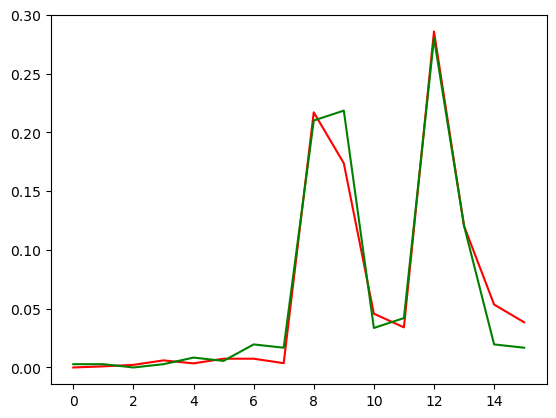

In [280]:
y=1
plt.plot([sum(df[(df['Y']==y)&(df['S']==1)&(df['X']==i)]['W'])/sum([sum(df[(df['Y']==y)&(df['S']==1)&(df['X']==i)]['W']) for i in x_range]) for i in x_range],color='r')
plt.plot([sum(df[(df['Y']==y)&(df['S']==0)&(df['X']==i)]['W'])/sum([sum(df[(df['Y']==y)&(df['S']==0)&(df['X']==i)]['W']) for i in x_range]) for i in x_range],color='g')

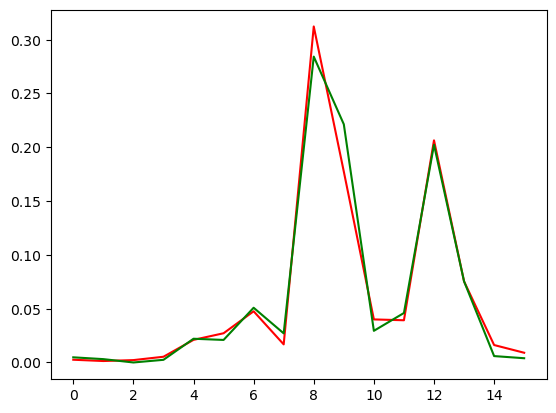

In [281]:
y=1
plt.plot([sum(rdata_base[(rdata_base['Y']==y)&(rdata_base['S']==1)&(rdata_base['X']==i)]['W'])/sum(sum(rdata_base[(rdata_base['Y']==y)&(rdata_base['S']==1)&(rdata_base['X']==i)]['W']) for i in x_range) for i in x_range],color='r')
plt.plot([sum(rdata_base[(rdata_base['Y']==y)&(rdata_base['S']==0)&(rdata_base['X']==i)]['W'])/sum(sum(rdata_base[(rdata_base['Y']==y)&(rdata_base['S']==0)&(rdata_base['X']==i)]['W']) for i in x_range) for i in x_range],color='g')

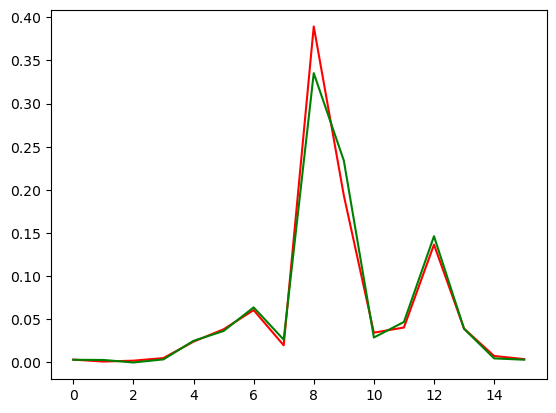

In [282]:
y=1
plt.plot([sum(rdata_part2[(rdata_part2['Y']==y)&(rdata_part2['S']==1)&(rdata_part2['X']==i)]['W'])/sum(sum(rdata_part2[(rdata_part2['Y']==y)&(rdata_part2['S']==1)&(rdata_part2['X']==i)]['W']) for i in x_range) for i in x_range],color='r')
plt.plot([sum(rdata_part2[(rdata_part2['Y']==y)&(rdata_part2['S']==0)&(rdata_part2['X']==i)]['W'])/sum(sum(rdata_part2[(rdata_part2['Y']==y)&(rdata_part2['S']==0)&(rdata_part2['X']==i)]['W']) for i in x_range) for i in x_range],color='g')

In [283]:
#report=pd.read_csv('C:/Users/zhouq/Documents/optimal_transport/report.csv')
performance=list(report.columns)[:-2]
methods=['origin','baseline','partial repair'] 
colors=['r','orange','c','g']
pivot=pd.pivot_table(report,index=['method','test set'],values=performance,aggfunc=[np.mean,np.std])
pivot

mean                                  \
                                  DI  f1 macro  f1 micro f1 weighted   
method         test set                                                
baseline       origin       0.368883  0.566078  0.775589    0.721034   
               re-weighted  0.365746  0.568132  0.821449    0.774611   
origin         origin       0.422208  0.592882  0.777885    0.734109   
               re-weighted  0.412713  0.596499  0.823650    0.785839   
partial repair origin       1.000000  0.430947  0.757307    0.652720   
               re-weighted  1.000000  0.448323  0.812663    0.728681   

                                 std                                  
                                  DI  f1 macro  f1 micro f1 weighted  
method         test set                                               
baseline       origin       0.108210  0.048423  0.005643    0.025042  
               re-weighted  0.096767  0.046200  0.004825    0.021878  
origin         origin       0.032628  0.002728  0.002099    0.003172  
               re-weighted  0.020836  0.003331  0.001020    0.002437  
partial repair origin       0.000000  0.000684  0.002114    0.002860  
               re-weighted  0.000000  0.001547  0.005075    0.007057

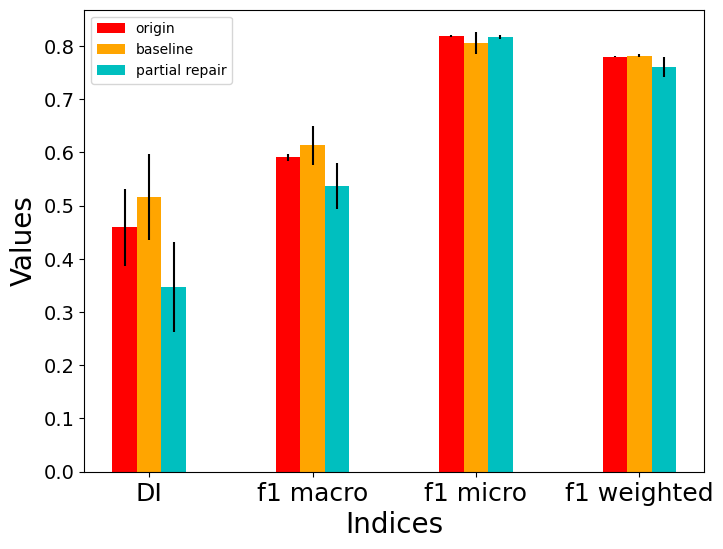

In [274]:
ind=np.arange(4)
width = 0.15

fig, ax1 = plt.subplots(figsize=(8,6))

i=0
for m in methods:
    sub=[pivot[('mean',p)][(m,'re-weighted')] for p in performance]
    err=[pivot[('std',p)][(m,'re-weighted')] for p in performance]
    #ax1.bar(ind+width*i,sub,width,alpha=0.5,color=colors[i],label=m) #,label=m
    ax1.bar(ind+width*i,sub,width,yerr=err,color=colors[i],label=m)
    i+=1
    
ax1.legend(fontsize=10)
ax1.set_xlabel('Indices', fontsize=20)
ax1.set_ylabel('Values', fontsize=20)

ax1.set_xticks(ind+width)
ax1.set_xticklabels([i for i in performance], fontsize=18)
ax1.tick_params(axis='y', which='major', labelsize=14)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#plt.savefig("plots/COMPAS4_bar.pdf",bbox_inches='tight')

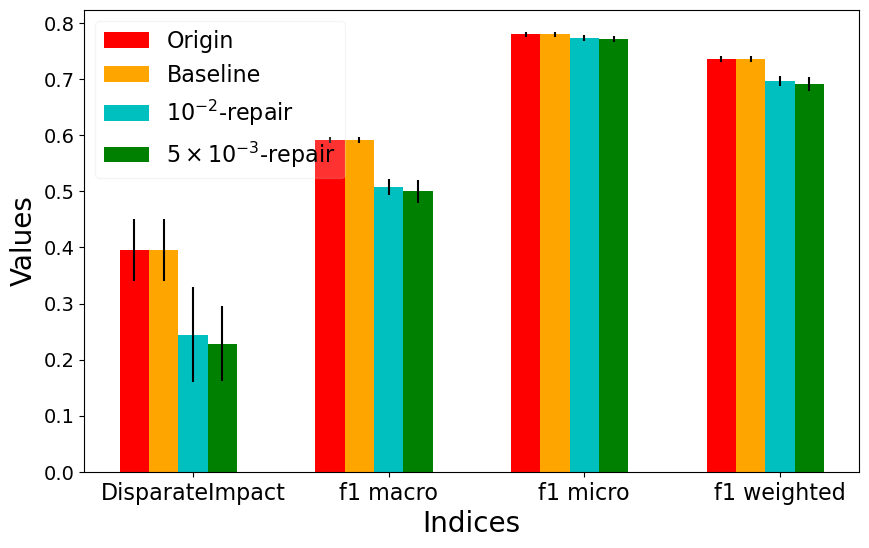

In [25]:
ind=np.arange(len(performance))
width = 0.15

fig, ax1 = plt.subplots(figsize=(10,6))

i=0
for m in methods:
    sub=[pivot[('mean',p)][m] for p in performance]
    err=[pivot[('std',p)][m] for p in performance]
    ax1.bar(ind+width*i,sub,width,yerr=err,color=colors[i],label=m)
    i+=1
    
ax1.legend(['Origin','Baseline',r'$10^{-2}$-repair',r'$5\times 10^{-3}$-repair'],fontsize=16,
           fancybox=True, framealpha=0.2)
ax1.set_xlabel('Indices', fontsize=20)
ax1.set_ylabel('Values', fontsize=20)

ax1.set_xticks(ind+width*2)
ax1.set_xticklabels(['DisparateImpact']+[i for i in performance[1:]], fontsize=16)
ax1.tick_params(axis='y', which='major', labelsize=14)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#plt.savefig("C:/Users/zhouq/Documents/optimal_transport/adult_bar.pdf",bbox_inches='tight')

In [73]:
clf=RandomForestClassifier(max_depth=4, random_state=0).fit(X_train[:,0:1],y_train,sample_weight=X_train[:,2])
y_pred=clf.predict(X_test[:,0:1])
# lower the better
print(DisparateImpact(X_test,y_pred),'DisparateImpact')
# higher the better
print(f1_score(y_test, y_pred, average='macro'),'f1 macro')
print(f1_score(y_test, y_pred, average='micro'),'f1 micro')
print(f1_score(y_test, y_pred, average='weighted'),'f1 weighted')

0.2882412643178193 DisparateImpact
0.596312721175936 f1 macro
0.7907465825446898 f1 micro
0.7474408588761946 f1 weighted


In [43]:
X_train_base=rdata_base[['X','S','W']].to_numpy()
y_train_base=rdata_base['Y'].to_numpy().astype('int8')
clf_base=RandomForestClassifier(max_depth=4, random_state=0)
clf_base.fit(X_train_base[:,0:1],y_train_base,sample_weight=X_train_base[:,2])
y_pred_base=clf_base.predict(X_test[:,0:1])
# lower the better
print(DisparateImpact(X_test,y_pred_base),'DisparateImpact')
# higher the better
print(f1_score(y_test,y_pred_base, average='macro'),'f1 macro')
print(f1_score(y_test,y_pred_base, average='micro'),'f1 micro')
print(f1_score(y_test,y_pred_base, average='weighted'),'f1 weighted')

0.2882412643178193 DisparateImpact
0.596312721175936 f1 macro
0.7907465825446898 f1 micro
0.7474408588761946 f1 weighted


In [45]:
X_train_part=rdata_part2[['X','S','W']].to_numpy()
y_train_part=rdata_part2['Y'].to_numpy().astype('int8')
clf_part= RandomForestClassifier(max_depth=4, random_state=0)
clf_part.fit(X_train_part[:,0:1],y_train_part,sample_weight=X_train_part[:,2])
y_pred_part=clf_part.predict(X_test[:,0:1])
# lower the better
print(DisparateImpact(X_test,y_pred_part),'DisparateImpact')
# higher the better
print(f1_score(y_test,y_pred_part, average='macro'),'f1 macro')
print(f1_score(y_test,y_pred_part, average='micro'),'f1 micro')
print(f1_score(y_test,y_pred_part, average='weighted'),'f1 weighted')

0.11474747474747474 DisparateImpact
0.520222571600147 f1 macro
0.7851384507535927 f1 micro
0.7125365046271059 f1 weighted


S=1: White
S=0: Black

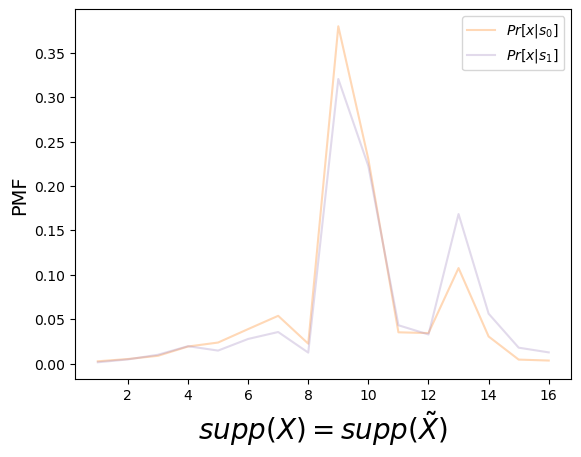

In [193]:
#plt.plot(x_range,dist['x'],label=r'$Pr[x]$',color='tab:blue')
plt.plot(x_range,dist['x_0'],label=r'$Pr[x|s_0]$',alpha=0.3,color='tab:orange')
plt.plot(x_range,dist['x_1'],label=r'$Pr[x|s_1]$',alpha=0.3,color='#9f86c0')
#plt.plot(x_range,dist['t_x'],label=r'$Pr[\tilde{x}]$',color='tab:green')
plt.ylabel('PMF',fontsize=14)
plt.xlabel(r'$supp(X)=supp(\tilde{X})$',fontsize=20)
plt.legend()
#plt.savefig('C:/Users/zhouq/Downloads/SourceTarget_adult.pdf',bbox_inches = 'tight')

In [ ]:
baseline(C,e,px,ptx,V,200)
total_repair(C,e,px,ptx,V,200)
partial_repair(C,e,px,ptx,V,1.0e-3,200)

In [ ]:
rdata_base=projection(data,baseline(C,e,px,ptx,V,200)[400])
rdata_part2=projection(data,partial_repair(C,e,px,ptx,V,1.0e-2,200)[600])
rdata_part3=projection(data,partial_repair(C,e,px,ptx,V,1.0e-3,200)[600])
rdata_total=projection(data,total_repair(C,e,px,ptx,V,200)[600])

In [ ]:
dist_origin=rdata_analysis(data,bin)
rdist_base=rdata_analysis(rdata_base,bin)
rdist_part2=rdata_analysis(rdata_part2,bin)
rdist_part3=rdata_analysis(rdata_part3,bin)
rdist_total=rdata_analysis(rdata_total,bin)